**Student Performance Prediction**

**Obective**

In this notebook, we will :

Build a prediction model on students academic pattern, then predict whether or not a student will pass the final exam based on certain information given.


In [ ]:
pip install snowflake-sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 6.3 MB/s eta 0:00:00


Importation of Libraries


In [ ]:
import snowflake.connector
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from snowflake.connector.pandas_tools import write_pandas
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


Connecting to snowflake warehouse



In [ ]:
 # Create a connection string
connection_string = (
)

# Create an SQLAlchemy engine
engine = create_engine(connection_string)

try:
    connection = engine.connect()
    connection.close()
    print("Connection to Snowflake successful!")
except Exception as e:
    print(f"Connection failed: {e}")




/usr/local/lib/python3.10/dist-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)


Connection to Snowflake successful!


Reading Data


In [ ]:
# Define your SQL query
#jamb = "SELECT * from Core.Jamb_performance_metrics"
#waec = "SELECT * from Core.Waec_performance_metrics"


# Read data into a pandas DataFrame
#jamb= pd.read_sql_query(jamb, engine)
#waec = pd.read_sql_query(waec, engine)

#waec.to_csv('waec.csv', index=False)
#jamb.to_csv('jamb.csv', index=False)

# Display the DataFrame
#print(jamb)
#(waec)

In [ ]:
# Move the file to a specific folder in your Google Drive
!cp waec.csv /content/drive/MyDrive/


cp: cannot stat 'waec.csv': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Two large datasets that have been generated specifically for this investigation will be used;

Waec: This is a record that illustrates the academic trends of students and graduates who have completed the waec at the school. The purpose is to use a trained model from alumnic to predict the success/failure rate of current students with similar characteristics.

Jamb: This is an external test written by only those who have completed their ssce programme and wish to continue their education at universities. This maintains track of the alumni who have authored jamb and aspiring ones, and also makes forecasts on their performance.

In [ ]:
waec = pd.read_csv('/content/drive/MyDrive/waec.csv')
jamb = pd.read_csv('/content/drive/MyDrive/jamb.csv')

<ipython-input-5-c1c81f9bc9f2>:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  waec = pd.read_csv('/content/drive/MyDrive/waec.csv')





Data Preprocessing

In [ ]:
waec.head()

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,number_of_votes,student_offence,disciplinary_action_taken,disciplinary_teacher,average_student_score,student_evaluation,waec_exam_year,waec_grade,average_student_minutes_attendance,average_expected_student_attendance
0,896544,1148,28,Wuraola Durodola Jaiyeola,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,Yes,...,0,NaN,NaN,NaN,54.3,Pass,NaN,NaN,5349,5380
1,268153,754,41,Oke Abosede Shekoni,Commercial,Male,Poor Condition,Senior Secondary School 1,Curent Student,No,...,0,NaN,NaN,NaN,58.0,Pass,NaN,NaN,5295,5380
2,267777,763,1,Segilola Alamu Salami,Science,Female,Very Good Condition,Senior Secondary School 1,Curent Student,No,...,0,NaN,NaN,NaN,54.3,Pass,NaN,NaN,8232,8260
3,573901,1060,29,Adedayo Mofifoluwa Oyeyemi,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,No,...,0,NaN,NaN,NaN,47.3,Fail,NaN,NaN,8151,8260
4,268215,754,19,Oke Abosede Shekoni,Commercial,Male,Poor Condition,Senior Secondary School 1,Curent Student,No,...,0,NaN,NaN,NaN,65.0,Pass,NaN,NaN,5299,5380


An overview of the common tables in the two dataset.

**attendance_day:** Contains the attendance of students
**calendar events:** Contains events and public holidays that the school hosted or participated in
**courses:** Contains the subjects offered in the school
**discipline_referrals**:Contains offenses and punishments of delinquent students

**eligibility:** Contains the eligibility of students as regards extracurricular activities

**eligibility activities:** Contains the extracurricular activities of students
**gradebook_grades:** Contains the scores of students of various assessment types
**marking_periods:** Contains the periods at which students are assessed. Eg. First term Midterm test

**parent:** Contains the list of parents that have children in the school

**portal_polls:** Contains the voting polls of students in evaluating their teachers

**school_gradelevels:** Contains the different classes in the
school In this context, JSS1 to SS3

**schools:** Contains a list of schools. In this context, only one school (Zacrac High School) is in the table.

**student_jamb_scores:** Contains the jamb scores of the alumni students
**student_waec_grades:** Contains the waec grades of the alumni students
**students**: Contains students and their information in the school
**students_course:** Contains students and the courses they studied and/or are studying.

**teachers:** Contains teachers in the school


In [ ]:
# Count duplicates in column '_course_id'
duplicate_counts = waec['student_course_id'].value_counts()

# Filter for only duplicates (counts > 1)
duplicates = duplicate_counts[duplicate_counts > 1].sum()

# Display the count of duplicates
print(duplicates)



202492


In [ ]:
#to remove the duplicates in the student_course_id due to several offence record of students per session

waec['offense_count'] = waec.groupby('student_course_id')['student_offence'].transform('count')
waec.drop_duplicates(subset='student_course_id', keep='first', inplace=True)

In [ ]:
waec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2337410 entries, 0 to 2490784
Data columns (total 31 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   student_course_id                    int64  
 1   student_id                           int64  
 2   course_id                            int64  
 3   student_name                         object 
 4   department                           object 
 5   gender                               object 
 6   health_condition                     object 
 7   student_class                        object 
 8   student_status                       object 
 9   bus_pickup                           object 
 10  bus_dropoff                          object 
 11  student_activity_status              object 
 12  student_extracurricular_activity     object 
 13  course                               object 
 14  course_class                         object 
 15  course_department                    

In [ ]:
waec[waec['student_course_id'] == 570018]

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,student_offence,disciplinary_action_taken,disciplinary_teacher,average_student_score,student_evaluation,waec_exam_year,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,offense_count
2490784,570018,1057,10,Adeniyi Folu Makinwa,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,No,...,NaN,NaN,NaN,67.7,Pass,NaN,NaN,5318,5380,0


In [ ]:
# Print unique values for all columns
for column in waec.columns:
    unique_values = waec[column].nunique()
    print(f"Unique values in column {column}: {unique_values}")

Unique values in column student_course_id: 2337410
Unique values in column student_id: 1710
Unique values in column course_id: 100
Unique values in column student_name: 1710
Unique values in column department: 3
Unique values in column gender: 2
Unique values in column health_condition: 4
Unique values in column student_class: 7
Unique values in column student_status: 4
Unique values in column bus_pickup: 2
Unique values in column bus_dropoff: 2
Unique values in column student_activity_status: 2
Unique values in column student_extracurricular_activity: 15
Unique values in column course: 28
Unique values in column course_class: 6
Unique values in column course_department: 4
Unique values in column parent: 647
Unique values in column parent_education: 4
Unique values in column teacher: 20
Unique values in column rating_type: 2
Unique values in column number_of_votes: 26
Unique values in column student_offence: 3
Unique values in column disciplinary_action_taken: 4
Unique values in column

In [ ]:
waec.describe ()

,student_course_id,student_id,course_id,number_of_votes,average_student_score,waec_exam_year,average_student_minutes_attendance,average_expected_student_attendance,offense_count
count,2.337410e+06,2.337410e+06,2.337410e+06,2.337410e+06,2.337410e+06,2429.000000,2.337410e+06,2.337410e+06,2.337410e+06
mean,1.168706e+06,1.160993e+03,2.226740e+01,4.323897e+00,5.685510e+01,2019.931247,7.859585e+11,7.939055e+11,1.225651e-01
std,6.747523e+05,2.455986e+02,1.402331e+01,3.207866e+01,8.659868e+00,0.798866,1.026276e+13,1.036635e+13,6.686664e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.770000e+01,2019.000000,5.272000e+03,5.380000e+03,0.000000e+00
25%,5.843532e+05,1.040000e+03,1.100000e+01,0.000000e+00,5.100000e+01,2019.000000,5.307000e+03,5.380000e+03,0.000000e+00
50%,1.168706e+06,1.190000e+03,2.100000e+01,0.000000e+00,5.700000e+01,2020.000000,5.342000e+03,5.380000e+03,0.000000e+00
75%,1.753058e+06,1.329000e+03,3.300000e+01,0.000000e+00,6.270000e+01,2021.000000,5.378000e+03,5.380000e+03,0.000000e+00
max,2.337410e+06,1.710000e+03,1.000000e+02,3.500000e+02,9.000000e+01,2021.000000,1.375186e+14,1.375279e+14,8.000000e+00


In [ ]:
waec.shape

(2337410, 31)

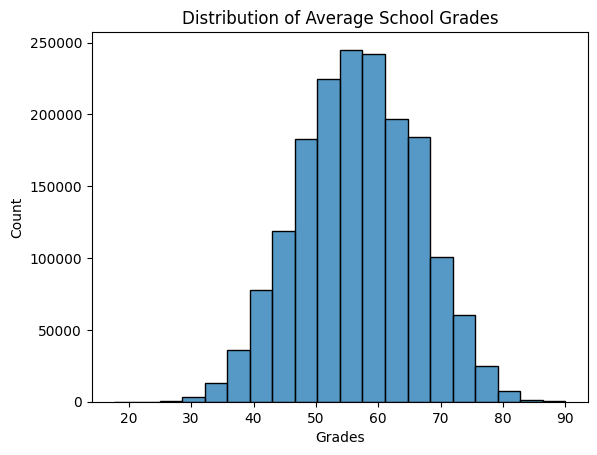

In [ ]:
# Distribution of average school grades
sns.histplot(waec['average_student_score'], bins=20)
plt.title('Distribution of Average School Grades')
plt.xlabel('Grades')
plt.ylabel('Count')
plt.show()

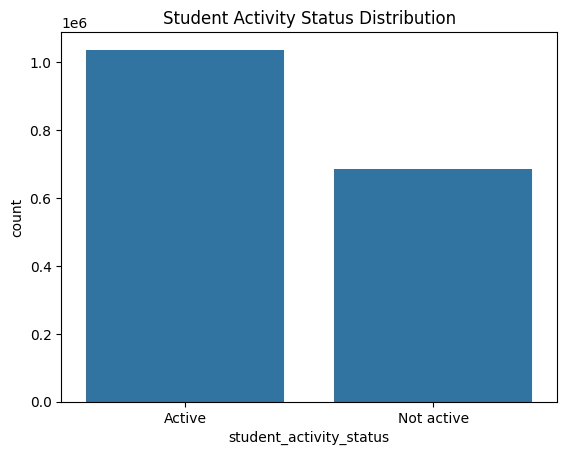

In [ ]:
# Distribution of student activity status
sns.countplot(x='student_activity_status', data=waec)
plt.title('Student Activity Status Distribution')
plt.show()

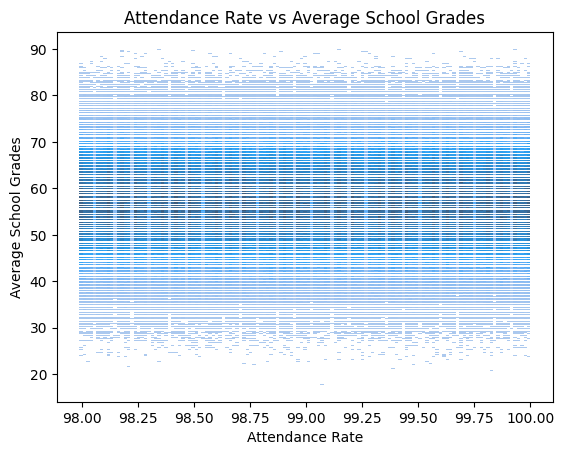

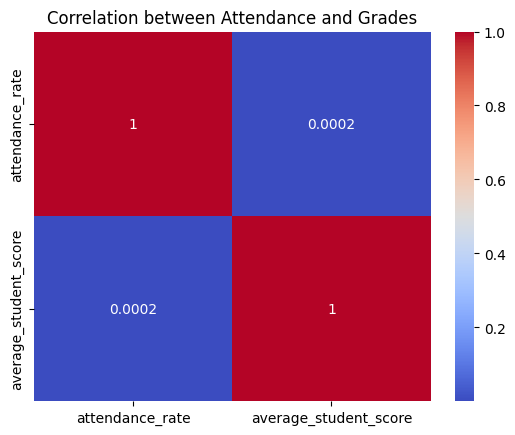

In [ ]:
# Attendance rate
waec['attendance_rate'] = waec['average_student_minutes_attendance'] / waec['average_expected_student_attendance'] *100

# Scatter plot to see the relationship between attendance and grades
sns.histplot(x='attendance_rate', y='average_student_score', data=waec)
plt.title('Attendance Rate vs Average School Grades')
plt.xlabel('Attendance Rate')
plt.ylabel('Average School Grades')
plt.show()

# Correlation matrix for attendance and grades
correlation_matrix = waec[['attendance_rate', 'average_student_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Attendance and Grades')
plt.show()


Since our Focus is predicting waec score by studing the academics records of the alumni, we will limit the scope of our data to carry the alumni and students that are in senior secondary school in their current year.


In [ ]:
scope = waec[
    waec['student_class'].isin(['Alumni', 'Senior Secondary School 1', 'Senior Secondary School 2', 'Senior Secondary School 3'])]
scope = pd.DataFrame(scope)
scope.reset_index(drop=True, inplace=True)

scope.head()


,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,disciplinary_action_taken,disciplinary_teacher,average_student_score,student_evaluation,waec_exam_year,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,offense_count,attendance_rate
0,896544,1148,28,Wuraola Durodola Jaiyeola,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,Yes,...,NaN,NaN,54.3,Pass,NaN,NaN,5349,5380,0,99.423792
1,268153,754,41,Oke Abosede Shekoni,Commercial,Male,Poor Condition,Senior Secondary School 1,Curent Student,No,...,NaN,NaN,58.0,Pass,NaN,NaN,5295,5380,0,98.420074
2,267777,763,1,Segilola Alamu Salami,Science,Female,Very Good Condition,Senior Secondary School 1,Curent Student,No,...,NaN,NaN,54.3,Pass,NaN,NaN,8232,8260,0,99.661017
3,573901,1060,29,Adedayo Mofifoluwa Oyeyemi,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,No,...,NaN,NaN,47.3,Fail,NaN,NaN,8151,8260,0,98.680387
4,268215,754,19,Oke Abosede Shekoni,Commercial,Male,Poor Condition,Senior Secondary School 1,Curent Student,No,...,NaN,NaN,65.0,Pass,NaN,NaN,5299,5380,0,98.494424


In [ ]:
scope.shape

(2186224, 32)

In [ ]:
scope.describe()

,student_course_id,student_id,course_id,number_of_votes,average_student_score,waec_exam_year,average_student_minutes_attendance,average_expected_student_attendance,offense_count
count,2.089001e+06,2.089001e+06,2.089001e+06,2.089001e+06,2.089001e+06,2429.000000,2.089001e+06,2.089001e+06,2.089001e+06
mean,1.283796e+06,1.223169e+03,2.295793e+01,4.553162e+00,5.685558e+01,2019.931247,7.892854e+11,7.972587e+11,1.232747e-01
std,6.197040e+05,1.621528e+02,1.415399e+01,3.297151e+01,8.659211e+00,0.798866,1.028442e+13,1.038814e+13,6.779334e-01
min,1.232800e+04,9.590000e+02,1.000000e+00,0.000000e+00,2.030000e+01,2019.000000,5.272000e+03,5.380000e+03,0.000000e+00
25%,7.706600e+05,1.090000e+03,1.100000e+01,0.000000e+00,5.100000e+01,2019.000000,5.307000e+03,5.380000e+03,0.000000e+00
50%,1.292910e+06,1.219000e+03,2.200000e+01,0.000000e+00,5.700000e+01,2020.000000,5.342000e+03,5.380000e+03,0.000000e+00
75%,1.815160e+06,1.345000e+03,3.300000e+01,0.000000e+00,6.270000e+01,2021.000000,5.378000e+03,5.380000e+03,0.000000e+00
max,2.337410e+06,1.710000e+03,1.000000e+02,3.500000e+02,9.000000e+01,2021.000000,1.375186e+14,1.375279e+14,7.000000e+00


In [ ]:
# Print unique values for all columns
for column in scope.columns:
    unique_values = scope[column].nunique()
    print(f"Unique values in column {column}: {unique_values}")

Unique values in column student_course_id: 2186224
Unique values in column student_id: 991
Unique values in column course_id: 100
Unique values in column student_name: 991
Unique values in column department: 3
Unique values in column gender: 2
Unique values in column health_condition: 4
Unique values in column student_class: 4
Unique values in column student_status: 4
Unique values in column bus_pickup: 2
Unique values in column bus_dropoff: 2
Unique values in column student_activity_status: 2
Unique values in column student_extracurricular_activity: 15
Unique values in column course: 28
Unique values in column course_class: 6
Unique values in column course_department: 4
Unique values in column parent: 647
Unique values in column parent_education: 4
Unique values in column teacher: 20
Unique values in column rating_type: 2
Unique values in column number_of_votes: 26
Unique values in column student_offence: 3
Unique values in column disciplinary_action_taken: 4
Unique values in column d

Feature Engineering


In [ ]:
#Assigningnumericalscore
#def numerical_data():
    scope['gender'] = scope['gender'].map({'Male': 0, 'Female': 1})
    scope['bus_pickup'] = scope['bus_pickup'].map({'No': 0, 'Yes': 1})
    scope['bus_dropoff'] = scope['bus_dropoff'].map({'No': 0, 'Yes': 1})
    scope['student_evaluation'] = scope['student_evaluation'].map({'Fail': 0, 'Pass': 1})
    #scope['Waec_grade_encoded'] = scope['Waec_grade_encoded'].map({'Fail': 0, 'Pass': 1})
    #waecalumni['performance_group'] = waecalumni['performance_group'].map({'Low': 0, 'Below Average': 1, 'Above Average': 2, 'High': 3})
    scope['student_activity_status'] = scope['student_activity_status'].map({'Not active': 0, 'Active': 1})
    scope['parent_education']= scope['parent_education'].map({'Primary': 1, 'Secondary': 2, 'Higher': 3, 'None': 0, 'nan': 0})
    scope['health_condition'] = scope['health_condition'].map({'Poor Condition': 0, 'Very Good Condition':3,'Average Condition':1,
'Good Condition':2 })

# Call the function to update the waecalumni DataFrame
#numerical_data()


In [ ]:
scope.head()

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,attendance_rate,offense_count,num_courses,department_focus,absenteeism,attendance_score_interaction,waec_status
0,896544,1148,28,Wuraola Durodola Jaiyeola,Science,1,3,Senior Secondary School 2,Curent Student,1,...,NaN,5349,5380,0.994238,0,1,1,31,53.987119,NaN
1,268153,754,41,Oke Abosede Shekoni,Commercial,0,0,Senior Secondary School 1,Curent Student,0,...,NaN,5295,5380,0.984201,0,1,1,85,57.083643,NaN
2,267777,763,1,Segilola Alamu Salami,Science,1,3,Senior Secondary School 1,Curent Student,0,...,NaN,8232,8260,0.996610,0,1,1,28,54.115932,NaN
3,573901,1060,29,Adedayo Mofifoluwa Oyeyemi,Science,1,3,Senior Secondary School 2,Curent Student,0,...,NaN,8151,8260,0.986804,0,1,1,109,46.675823,NaN
4,269039,753,3,Osunleke Omotola Fadipe,Arts,0,1,Senior Secondary School 1,Curent Student,1,...,NaN,5375,5380,0.999071,0,1,1,5,53.949814,NaN


In [ ]:
# Number of courses per student
scope['num_courses'] = scope.groupby('student_id')['student_course_id'].transform('count')

# Specialization in a course department (count of courses in a single department)
scope['department_focus'] = scope.groupby(['student_id', 'course_department'])['student_course_id'].transform('count')


In [ ]:
scope['absenteeism'] = scope['average_expected_student_attendance'] - scope['average_student_minutes_attendance']
scope['attendance_rate'] = scope['average_student_minutes_attendance'] / scope['average_expected_student_attendance']


In [ ]:
#creating interaction features
scope['attendance_score_interaction'] = scope['attendance_rate'] * scope['average_student_score']



In [ ]:
# Define a mapping from WAEC grades to pass/fail
pass_fail_mapping = {
    'A1': 'Pass',
    'B2': 'Pass',
    'B3': 'Pass',
    'C4': 'Pass',
    'C5': 'Pass',
    'C6': 'Pass',
    'D7': 'Fail',
    'E8': 'Fail',
    'F9': 'Fail'
}

# Apply the mapping to determine pass/fail
scope['waec_grade'] = scope['waec_grade'].map(pass_fail_mapping)



In [ ]:
 scope['waec_status'] = scope['waec_grade'].map({'Fail': 0, 'Pass': 1})

In [ ]:
scope[['waec_grade']]

,waec_grade
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
2186219,NaN
2186220,NaN
2186221,NaN
2186222,NaN


In [ ]:
scope.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186224 entries, 0 to 2186223
Data columns (total 37 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   student_course_id                    int64  
 1   student_id                           int64  
 2   course_id                            int64  
 3   student_name                         object 
 4   department                           object 
 5   gender                               int64  
 6   health_condition                     int64  
 7   student_class                        object 
 8   student_status                       object 
 9   bus_pickup                           int64  
 10  bus_dropoff                          int64  
 11  student_activity_status              int64  
 12  student_extracurricular_activity     object 
 13  course                               object 
 14  course_class                         object 
 15  course_department               

MODEL

In [ ]:
# Filter rows where student_status contains 'alumni'
waecalumni = scope[scope['student_status'].str.contains('Alumni', case=False, na=False)]
waecalumni =pd.DataFrame(waecalumni)
waecalumni.reset_index(drop=True, inplace=True)
waecalumni.head()

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,offense_count,attendance_rate,num_courses,department_focus,absenteeism,attendance_score_interaction,waec_status
0,86311,1451,95,Motunrayo Olanrewaju Makinde,Arts,0,3,Alumni,2021 Alumni,1,...,Fail,5340,5380,0,0.992565,495,24,40,56.278439,0.0
1,86322,1451,63,Motunrayo Olanrewaju Makinde,Arts,0,3,Alumni,2021 Alumni,1,...,NaN,8238,8260,0,0.997337,495,471,22,54.853511,NaN
2,87280,1459,73,Olanrewaju Adeleke Awolowo,Science,1,3,Alumni,2021 Alumni,0,...,NaN,5285,5380,0,0.982342,405,18,95,62.869888,NaN
3,86573,1516,59,Adigun Oluwafemi Olowokeere,Arts,1,3,Alumni,2021 Alumni,1,...,NaN,5349,5380,0,0.994238,495,24,31,58.361766,NaN
4,87155,1456,85,Omolabake Arinola Ogunbiyi,Science,1,3,Alumni,2021 Alumni,0,...,Fail,8146,8260,0,0.986199,405,18,114,62.426368,0.0


In [ ]:
waecalumni.shape

(108205, 37)

In [ ]:
numfeature = waecalumni.select_dtypes(exclude=['object'])


In [ ]:
numfeature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108205 entries, 0 to 108204
Data columns (total 22 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   student_course_id                    108205 non-null  int64  
 1   student_id                           108205 non-null  int64  
 2   course_id                            108205 non-null  int64  
 3   gender                               108205 non-null  int64  
 4   health_condition                     108205 non-null  int64  
 5   bus_pickup                           108205 non-null  int64  
 6   bus_dropoff                          108205 non-null  int64  
 7   student_activity_status              108205 non-null  int64  
 8   parent_education                     57570 non-null   float64
 9   number_of_votes                      108205 non-null  int64  
 10  average_student_score                108205 non-null  float64
 11  student_evalu

In [ ]:
numfeatureclean= numfeature.dropna(subset=['waec_status'])



In [ ]:
# Define features (X) and target (y)
X = numfeatureclean.drop(columns=['waec_status', 'student_id', 'department_focus','student_course_id', 'course_id','waec_exam_year'])
y = numfeatureclean['waec_status']

# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_ids = waecalumni.loc[X_test.index, ['student_course_id', 'course']]  # Keep the identifiers for the test set

# Define a reduced parameter grid for quicker grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV with Random Forest model and reduced parameter grid
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                              cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search model
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and the best score from the grid search
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

# Output the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Train the model with the best parameters
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Output test set performance
print("Test Set Accuracy:", accuracy)
print("Test Set F1 Score:", f1)
print("Test Set AUC Score:", roc_auc)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.5362318840579711
Test Set Accuracy: 0.6
Test Set F1 Score: 0.45454545454545453
Test Set AUC Score: 0.5848214285714286


In [ ]:
output_df = pd.DataFrame({
    'student_course_id': test_ids['student_course_id'],  # Get the stored identifiers
    'course': test_ids['course'],                      # Get the course information
    'predicted_status': y_pred,
    'actual_status': y_test.values                     # Ensure to convert y_test to a suitable format
})


print(output_df)

       student_course_id                 course  predicted_status  \
96064              89845              Economics               0.0   
55855              92121               Commerce               0.0   
28375              88691              Chemistry               0.0   
28229              89613            Mathematics               1.0   
68574              86368              Economics               1.0   
...                  ...                    ...               ...   
42627              88693              Geography               0.0   
14833              87659       English Language               1.0   
68300              86276  Literature in English               0.0   
28291              92897              Geography               0.0   
227                88324              Geography               0.0   

       actual_status  
96064            0.0  
55855            0.0  
28375            0.0  
28229            1.0  
68574            1.0  
...              ...  
42627     

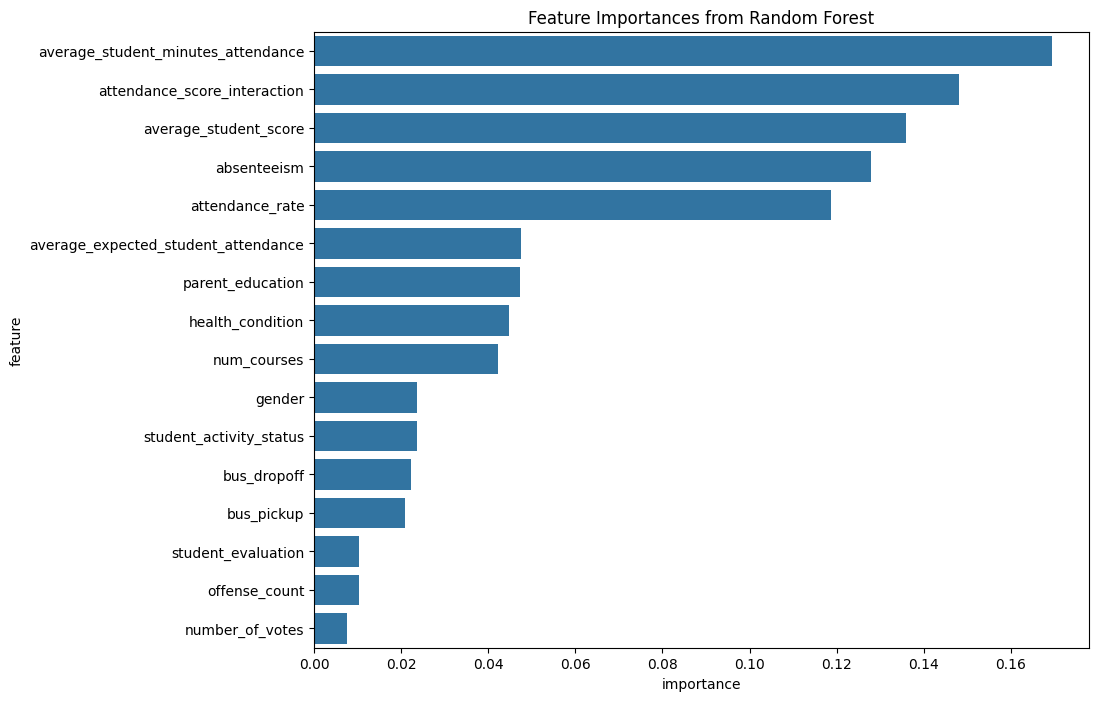

In [ ]:
# Get feature importances from the tuned model
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()


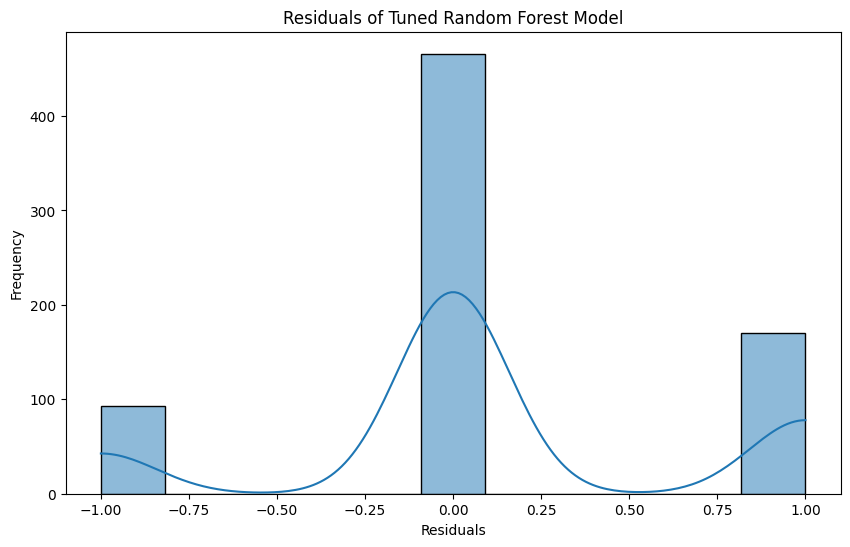

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals of Tuned Random Forest Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


Predictions for current_students

In [ ]:
import joblib

# Save the trained model
joblib.dump(best_rf_model, 'final_random_forest_model.pkl')

['final_random_forest_model.pkl']

In [ ]:
# Load the model later for predictions
loaded_model = joblib.load('final_random_forest_model.pkl')

In [ ]:
current_students = scope[scope['student_status'].str.contains('Curent Student', case=False, na=False)]
current_students =pd.DataFrame(current_students)
#current_students.reset_index(drop=True, inplace=True)
current_students.head()

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,offense_count,attendance_rate,num_courses,department_focus,absenteeism,attendance_score_interaction,waec_status
0,896544,1148,28,Wuraola Durodola Jaiyeola,Science,1,3,Senior Secondary School 2,Curent Student,1,...,NaN,5349,5380,0,0.994238,3492,3432,31,53.987119,NaN
1,268153,754,41,Oke Abosede Shekoni,Commercial,0,0,Senior Secondary School 1,Curent Student,0,...,NaN,5295,5380,0,0.984201,215,213,85,57.083643,NaN
2,267777,763,1,Segilola Alamu Salami,Science,1,3,Senior Secondary School 1,Curent Student,0,...,NaN,8232,8260,0,0.996610,387,381,28,54.115932,NaN
3,573901,1060,29,Adedayo Mofifoluwa Oyeyemi,Science,1,3,Senior Secondary School 2,Curent Student,0,...,NaN,8151,8260,0,0.986804,3492,3432,109,46.675823,NaN
4,268215,754,19,Oke Abosede Shekoni,Commercial,0,0,Senior Secondary School 1,Curent Student,0,...,NaN,5299,5380,0,0.984944,215,213,81,64.021375,NaN


In [ ]:
current_students.shape

(2078019, 37)

In [ ]:
numfeature1 = current_students.select_dtypes(exclude=['object'])
numfeature1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2078019 entries, 0 to 2186223
Data columns (total 22 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   student_course_id                    int64  
 1   student_id                           int64  
 2   course_id                            int64  
 3   gender                               int64  
 4   health_condition                     int64  
 5   bus_pickup                           int64  
 6   bus_dropoff                          int64  
 7   student_activity_status              int64  
 8   parent_education                     float64
 9   number_of_votes                      int64  
 10  average_student_score                float64
 11  student_evaluation                   int64  
 12  waec_exam_year                       float64
 13  average_student_minutes_attendance   int64  
 14  average_expected_student_attendance  int64  
 15  offense_count                        

In [ ]:
# Preprocessing new data

X_new = X_new[X.columns]

#['waec_status', 'student_id', 'department_focus','student_course_id', 'course_id','waec_exam_year'])

print(X.columns)
print(X_new.columns)

Index(['gender', 'health_condition', 'bus_pickup', 'bus_dropoff',
       'student_activity_status', 'parent_education', 'number_of_votes',
       'average_student_score', 'student_evaluation',
       'average_student_minutes_attendance',
       'average_expected_student_attendance', 'attendance_rate',
       'offense_count', 'num_courses', 'absenteeism',
       'attendance_score_interaction'],
      dtype='object')
Index(['gender', 'health_condition', 'bus_pickup', 'bus_dropoff',
       'student_activity_status', 'parent_education', 'number_of_votes',
       'average_student_score', 'student_evaluation',
       'average_student_minutes_attendance',
       'average_expected_student_attendance', 'attendance_rate',
       'offense_count', 'num_courses', 'absenteeism',
       'attendance_score_interaction'],
      dtype='object')


In [ ]:
# Making predictions
new_predictions = loaded_model.predict(X_new)

# If you need to assign the predictions back to the original DataFrame
current_students['predicted_waec_status'] = new_predictions



In [ ]:
# If you want to save or display the predictions
print(current_students[['student_course_id', 'student_id','course', 'predicted_waec_status']])  # Assuming you want these columns in the output

         student_course_id  student_id                       course  \
0                   896544        1148              Civic Education   
1                   268153         754  Christian Religious Studies   
2                   267777         763                  Mathematics   
3                   573901        1060                  Mathematics   
4                   268215         754               Social Studies   
...                    ...         ...                          ...   
2186219             569744        1057             English Language   
2186220             569796        1057             Business Studies   
2186221             569822        1057         Agricultural Science   
2186222             569974        1057               Home Economics   
2186223             570018        1057         Agricultural Science   

         predicted_waec_status  
0                          0.0  
1                          0.0  
2                          1.0  
3              

In [ ]:
write_pandas(
    conn,
    current_students[['student_course_id', 'predicted_waec_status']],
    'Waec_Predicted_Performance',
    auto_create_table=True,
    #overwrite=True  # Set to True if you want to replace the existing data
)
print("Predictions written to the 'Waec_Predicted_Performance' table in Snowflake.")

<ipython-input-134-d0b9336a6a5a>:1: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  write_pandas(


Predictions written to the 'Waec_Predicted_Performance' table in Snowflake.


In [ ]:
waec[waec['student_course_id'] == 573901]

,student_course_id,student_id,course_id,student_name,department,gender,health_condition,student_class,student_status,bus_pickup,...,student_offence,disciplinary_action_taken,disciplinary_teacher,average_student_score,student_evaluation,waec_exam_year,waec_grade,average_student_minutes_attendance,average_expected_student_attendance,offense_count
3,573901,1060,29,Adedayo Mofifoluwa Oyeyemi,Science,Female,Very Good Condition,Senior Secondary School 2,Curent Student,No,...,NaN,NaN,NaN,47.3,Fail,NaN,NaN,8151,8260,0


JAMB STUDENTS


In [ ]:

jamb.head()




,student_id,student_class,student_status,department,gender,student_parent,parent_education,student_activity_status,student_extracurricular_activity,average_student_minutes_attendance,average_expected_student_attendance,average_student_score,student_school_performance,student_offence,disciplinary_action_taken,disciplinary_teacher,jamb_exam_year,jamb_score,jamb_performance
0,34,Junior Secondary School 1,Curent Student,NaN,Male,Ogunde Ajani Adeleke,Primary,Active,Science Club,1828012938,1849118723,55.2,Pass,NaN,NaN,NaN,NaN,NaN,NaN
1,75,Junior Secondary School 1,Curent Student,NaN,Male,Olubode Morolake Omotoun,No education,Not active,NaN,5929,5997,60.1,Pass,NaN,NaN,NaN,NaN,NaN,NaN
2,145,Junior Secondary School 1,Curent Student,NaN,Male,Ojo Mojisola Akinkunmi,No education,Active,Track and Field,5937,5997,53.5,Pass,NaN,NaN,NaN,NaN,NaN,NaN
3,234,Junior Secondary School 1,Curent Student,NaN,Female,Olukotun Omotola Bunmi,No education,Active,Coding Club,5944,5997,58.3,Pass,NaN,NaN,NaN,NaN,NaN,NaN
4,562,Junior Secondary School 3,Curent Student,NaN,Female,Bakare Ikeoluwa Toluwanimi,Primary,Active,Basketball Team,2312589254436,2341139461170,57.1,Pass,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Print unique values for all columns
for column in jamb.columns:
    unique_values = jamb[column].nunique()
    print(f"Unique values in column {column}: {unique_values}")

Unique values in column student_id: 1710
Unique values in column student_class: 7
Unique values in column student_status: 4
Unique values in column department: 3
Unique values in column gender: 2
Unique values in column student_parent: 647
Unique values in column parent_education: 4
Unique values in column student_activity_status: 2
Unique values in column student_extracurricular_activity: 15
Unique values in column average_student_minutes_attendance: 1519
Unique values in column average_expected_student_attendance: 1478
Unique values in column average_student_score: 91
Unique values in column student_school_performance: 2
Unique values in column student_offence: 3
Unique values in column disciplinary_action_taken: 4
Unique values in column disciplinary_teacher: 20
Unique values in column jamb_exam_year: 3
Unique values in column jamb_score: 105
Unique values in column jamb_performance: 2


In [ ]:
jamb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   student_id                           1713 non-null   int64  
 1   student_class                        1713 non-null   object 
 2   student_status                       1713 non-null   object 
 3   department                           992 non-null    object 
 4   gender                               1713 non-null   object 
 5   student_parent                       1713 non-null   object 
 6   parent_education                     1713 non-null   object 
 7   student_activity_status              1713 non-null   object 
 8   student_extracurricular_activity     1074 non-null   object 
 9   average_student_minutes_attendance   1713 non-null   int64  
 10  average_expected_student_attendance  1713 non-null   int64  
 11  average_student_score         

In [ ]:
categorical_columns = ['student_class', 'student_status', 'department', 'gender',
                       'student_parent', 'parent_education', 'student_activity_status',
                       'student_extracurricular_activity', 'student_school_performance',
                       'student_offence', 'disciplinary_action_taken', 'disciplinary_teacher']

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    jamb[col] = le.fit_transform(jamb[col])
    label_encoders[col] = le

In [ ]:

jamb_filtered =jamb.dropna(subset=['jamb_score', 'jamb_performance'])


jamb_filtered.shape



(241, 19)

In [ ]:
jamb_filtered.head()

,student_id,student_class,student_status,department,gender,student_parent,parent_education,student_activity_status,student_extracurricular_activity,average_student_minutes_attendance,average_expected_student_attendance,average_student_score,student_school_performance,student_offence,disciplinary_action_taken,disciplinary_teacher,jamb_exam_year,jamb_score,jamb_performance
6,1686,0,0,0,0,314,3,0,1,818109689312,824203022151,56.5,1,3,4,20,2019.0,112.0,Fail
18,1593,0,1,1,0,368,1,1,15,1187768829719,1195358996621,57.2,1,3,4,20,2020.0,137.0,Fail
20,1688,0,0,2,1,511,1,1,15,670507241923,673694239543,56.8,1,3,4,20,2019.0,151.0,Fail
24,1465,0,2,0,1,331,2,0,12,544721711264,549763745967,56.8,1,3,4,20,2021.0,150.0,Fail
25,1710,0,0,2,1,546,3,0,8,167739374,169398940,57.2,1,3,4,20,2019.0,113.0,Fail


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE



# Define the feature set X and target y
X = jamb.drop(columns=[
    'student_id', 'jamb_score', 'jamb_exam_year', 'jamb_performance', 'student_class', 'student_status',
    'department', 'student_parent', 'student_extracurricular_activity', 'disciplinary_action_taken',
    'disciplinary_teacher', 'jamb_exam_year'
])
y = (jamb['jamb_performance'] == 'Pass').astype(int)  # Convert to binary: 1 if 'Pass', 0 otherwise

# Split data into those who have and haven't written JAMB
jamb_written = jamb.dropna(subset=['jamb_performance'])
jamb_not_written = jamb[jamb['jamb_performance'].isna()]

# Further split the data into train and test sets for students who have written JAMB
X_written = X.loc[jamb_written.index]
y_written = y.loc[jamb_written.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_written, y_written, test_size=0.3, random_state=42, stratify=y_written)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
#rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10})
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate the model on the test set
y_pred_test = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy)
print("Classification Report:\n", report)

# Make predictions on students who haven't written JAMB
X_not_written = X.loc[jamb_not_written.index]
jamb_predictions = rf_model.predict(X_not_written)

# Attach predictions to the original data for students who haven't written JAMB
jamb_not_written['predicted_status'] = jamb_predictions

# Preview the predictions
print(jamb_not_written[['student_id', 'predicted_status']].head())



Test Set Accuracy: 0.6986301369863014
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        59
           1       0.21      0.21      0.21        14

    accuracy                           0.70        73
   macro avg       0.51      0.51      0.51        73
weighted avg       0.70      0.70      0.70        73

   student_id  predicted_status
0          34                 0
1          75                 0
2         145                 0
3         234                 0
4         562                 0


<ipython-input-14-631ac9922994>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jamb_not_written['predicted_status'] = jamb_predictions


In [ ]:
import snowflake.connector


conn = snowflake.connector.connect(
    user='DATABADDIES2024',
    password='@Databaddies2_',
    account='ya78182.eu-west-2.aws',
    warehouse='COMPUTE_WH',
    database='DATAFESTAFRICA',
    schema='CORE'
)


In [ ]:
write_pandas(
    conn,
    jamb_not_written[['student_id', 'predicted_status']],
    'Jamb_Predicted_Performance',
    auto_create_table=True,
    #overwrite=True  # Set to True if you want to replace the existing data
)
print("Predictions written to the 'Jamb_Predicted_Performance' table in Snowflake.")



<ipython-input-18-315c011f3b5f>:1: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  write_pandas(


Predictions written to the 'Jamb_Predicted_Performance' table in Snowflake.
